In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
import catboost
from catboost import CatBoostRegressor
import xgboost as xgb

## Basic XGBoost

In [3]:
df = pd.read_csv('C:\\Users\\user\\Desktop\\ML\\project\\Bank_Marketing_Split_dataset_with_allocations.csv')
columns_keep = ['Age', 
'MaritalStatus',
'EducationLevel',
'AnnualIncome',
'NetWorth',
'AccountBalance',
'InvestmentPortfolioValue',
'SalaryCategory',
'RiskRating',
'CustomerSegment',
'HasMortgage',
'HasPersonalLoan']

In [4]:
numerical_columns = df[columns_keep].select_dtypes(include=['number']).columns
numerical_columns = [col for col in numerical_columns if col not in ['US_Equity', 'International_Equity', 'Bonds', 'REIT', 'Cash']]
categorical_columns = df[columns_keep].select_dtypes(exclude=['number']).columns

In [5]:
column_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),  # Apply StandardScaler to numerical columns
        ('cat', OneHotEncoder(), categorical_columns)  # Apply OneHotEncoder to categorical columns
    ])

# Step 3: Prepare the features and target
X = df[columns_keep]
# X = df[[col for col in df.columns if col not in ['US_Equity', 'International_Equity', 'Bonds', 'REIT', 'Cash']]]
y = df[['US_Equity', 'International_Equity', 'Bonds', 'REIT', 'Cash']]

# Apply the column transformer to the features
X_scaled = column_transformer.fit_transform(X)

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')
xgboost_model.fit(X_train, y_train)

xgboost_preds = xgboost_model.predict(X_test)
xgboost_rmse = np.sqrt(mean_squared_error(y_test, xgboost_preds))
xgboost_r2 = r2_score(y_test, xgboost_preds)

print(f"XGBoost RMSE: {xgboost_rmse}")
print(f"XGBoost R²: {xgboost_r2}")

XGBoost RMSE: 0.06368417533295874
XGBoost R²: 0.4291973114013672


In [9]:
from sklearn.multioutput import MultiOutputRegressor

xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=800,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=1,
    reg_lambda=1,
    random_state=42
)

multi_xgb = MultiOutputRegressor(xgb_base)

multi_xgb.fit(X_train, y_train)

y_pred = multi_xgb.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 0.06110258764422242
R2: 0.479010671377182


## Multi-Regressor XGBoost

In [59]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# =========================================================
# 1. 讀取資料
# =========================================================
df = pd.read_csv(
    r"C:\Users\user\Desktop\ML\project\Bank_Marketing_Split_dataset_with_allocations.csv"
)

# =========================================================
# 2. 指定可用的 feature 欄位 & target 欄位
# =========================================================
columns_keep = [
    'Age', 
    'MaritalStatus',
    'EducationLevel',
    'AnnualIncome',
    'NetWorth',
    'AccountBalance',
    'InvestmentPortfolioValue',
    'SalaryCategory',
    'RiskRating',
    'CustomerSegment',
    'HasMortgage',
    'HasPersonalLoan'
]

target_cols = ['US_Equity', 'International_Equity', 'Bonds', 'REIT', 'Cash']

# 特徵 X、標籤 y
X = df[columns_keep].copy()
y = df[target_cols].copy()

# =========================================================
# 3. 建立 ColumnTransformer（數值標準化 + 類別 one-hot）
# =========================================================
numerical_columns = X.select_dtypes(include=['number']).columns.tolist()
categorical_columns = X.select_dtypes(exclude=['number']).columns.tolist()

column_transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns),
    ]
)

# 擬合轉換器並轉換 X
X_scaled = column_transformer.fit_transform(X)   # 會得到一個 numpy array / sparse matrix

# =========================================================
# 4. train / test 切分
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

# =========================================================
# 5. Optuna 找到的最佳 XGBoost 參數（你貼 log 的那組）
# =========================================================
best_params = {
    'max_depth': 3,
    'learning_rate': 0.010134899966747631,
    'subsample': 0.7774403163202805,
    'colsample_bytree': 0.813047771878503,
    'n_estimators': 1487,
    'reg_lambda': 1.0801284270760778,
    'reg_alpha': 4.674414318506555,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',     # 版本不支援放在 fit，就放在這裡
    'random_state': 42,
}

# =========================================================
# 6. 針對每一個 target 訓練一個 XGBoost model
# =========================================================
models = {}
y_pred_dict = {}

for col in target_cols:
    print(f"\n🚀 Training XGBoost for target: {col}")

    model = xgb.XGBRegressor(**best_params)

    # 這裡會印出 validation rmse（eval_set）
    model.fit(
        X_train,
        y_train[col],
        eval_set=[(X_test, y_test[col])],
        verbose=200,       # 每 200 iter 印一次 log
        # ⚠️ 你的 xgboost 版本不支援 early_stopping_rounds，就先不要用
    )

    models[col] = model
    y_pred_dict[col] = model.predict(X_test)

# =========================================================
# 7. 合併五個 target 的預測，計算整體 RMSE / R²
# =========================================================
y_pred = np.column_stack([y_pred_dict[c] for c in target_cols])

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n==============================")
print("📊 FINAL XGBOOST (MULTI-TARGET, TUNED) RESULTS")
print("==============================")
print(f"RMSE: {rmse:.6f}")
print(f"R²  : {r2:.6f}")

# （可選）如果你想看每一個 target 自己的表現：
print("\n📊 Per-target metrics:")
for i, col in enumerate(target_cols):
    rmse_i = np.sqrt(mean_squared_error(y_test[col], y_pred[:, i]))
    r2_i = r2_score(y_test[col], y_pred[:, i])
    print(f"{col:20s}  RMSE = {rmse_i:.6f}   R² = {r2_i:.6f}")



🚀 Training XGBoost for target: US_Equity
[0]	validation_0-rmse:0.08724
[200]	validation_0-rmse:0.06281
[400]	validation_0-rmse:0.06223
[600]	validation_0-rmse:0.06221
[800]	validation_0-rmse:0.06222
[1000]	validation_0-rmse:0.06222
[1200]	validation_0-rmse:0.06223
[1400]	validation_0-rmse:0.06223
[1486]	validation_0-rmse:0.06223

🚀 Training XGBoost for target: International_Equity
[0]	validation_0-rmse:0.06544
[200]	validation_0-rmse:0.04718
[400]	validation_0-rmse:0.04669
[600]	validation_0-rmse:0.04666
[800]	validation_0-rmse:0.04666
[1000]	validation_0-rmse:0.04666
[1200]	validation_0-rmse:0.04666
[1400]	validation_0-rmse:0.04666
[1486]	validation_0-rmse:0.04666

🚀 Training XGBoost for target: Bonds
[0]	validation_0-rmse:0.06544
[200]	validation_0-rmse:0.04718
[400]	validation_0-rmse:0.04669
[600]	validation_0-rmse:0.04666
[800]	validation_0-rmse:0.04666
[1000]	validation_0-rmse:0.04666
[1200]	validation_0-rmse:0.04666
[1400]	validation_0-rmse:0.04666
[1486]	validation_0-rmse:0.046

C:\Users\user\AppData\Local\Temp\ipykernel_25724\544784098.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_agg, x="Importance", y="Feature", palette="mako")


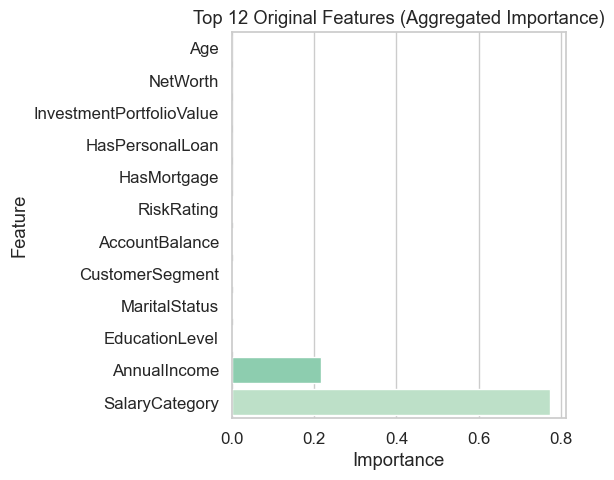

In [68]:
feature_names = column_transformer.get_feature_names_out()
avg_importance = np.zeros(len(feature_names))
for col in target_cols:
    avg_importance += models[col].feature_importances_
avg_importance /= len(target_cols)

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": avg_importance,
}).sort_values("Importance", ascending=False)


def aggregate_importance(importances, feature_names):
    agg = {}
    for imp, name in zip(importances, feature_names):
        # name 例如: "num__Age" or "cat__MaritalStatus_Single"
        parts = name.split("__")
        if len(parts) == 2:
            _, rest = parts
        else:
            rest = name
        base = rest.split("_")[0]   # 把 "MaritalStatus_Single" → "MaritalStatus"
        agg[base] = agg.get(base, 0.0) + imp
    agg_df = pd.DataFrame({"Feature": list(agg.keys()), "Importance": list(agg.values())})
    return agg_df.sort_values("Importance", ascending=False)

agg_df = aggregate_importance(avg_importance, feature_names)
top_k = 12
top_agg = agg_df.head(top_k).iloc[::-1]

plt.figure(figsize=(6, 5))
sns.barplot(data=top_agg, x="Importance", y="Feature", palette="mako")
plt.title(f"Top {top_k} Original Features (Aggregated Importance)")
plt.tight_layout()
plt.show()


## K-means + Multi-Regressor XGBoost

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans

In [88]:
k = 4  # try 3,4,5 later
kmeans_y = KMeans(n_clusters=k, random_state=42)
portfolio_clusters = kmeans_y.fit_predict(y)

df["PortfolioSegment"] = portfolio_clusters

# remap: aggressive=0, balanced=1, conservative=2 (optional)
segment_names = {i:f"Segment_{i}" for i in range(k)}
df["PortfolioSegment"] = df["PortfolioSegment"].map(segment_names)

print(df.groupby("PortfolioSegment")[target_cols].mean())  # 👁 inspect persona profiles

# Train/test split but segmentation must be based on y
X_train, X_test, y_train, y_test, seg_train, seg_test = train_test_split(
    X_scaled, y, portfolio_clusters, test_size=0.2, random_state=42
)

# Train per-segment XGBoost
models = {s:{} for s in range(k)}

for s in range(k):
    idx = (seg_train == s)
    print(f"\n🚀 Training XGBoost for Portfolio Segment {s} ({idx.sum()} investors)")
    for t in target_cols:
        model = xgb.XGBRegressor(**best_params)
        model.fit(X_train[idx], y_train[t][idx])
        models[s][t] = model

# Predict via segment assignment
preds = np.zeros_like(y_test.values)
for i in range(len(X_test)):
    seg = seg_test[i]
    for j,t in enumerate(target_cols):
        preds[i,j] = models[seg][t].predict(X_test[i].reshape(1,-1))[0]

print(f'\n')

# Evaluate
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import jensenshannon


xgboost_r2 = r2_score(y_test, xgboost_preds)
print(f"XGBoost R²: {xgboost_r2}")

cosine_scores = [
    cosine_similarity([y_test.values[i]], [preds[i]])[0][0]
    for i in range(len(y_test))
]

print("Average cosine similarity:", np.mean(cosine_scores))

jsd_scores = [
    jensenshannon(y_test.values[i], preds[i])  # lower is better
    for i in range(len(y_test))
]

print("Average Jensen-Shannon Divergence:", np.mean(jsd_scores))

                  US_Equity  International_Equity     Bonds      REIT  \
PortfolioSegment                                                        
Segment_0          0.167517              0.125637  0.174363  0.083758   
Segment_1          0.243096              0.182322  0.117678  0.121548   
Segment_2          0.360000              0.270000  0.030000  0.180000   
Segment_3          0.080000              0.060000  0.240000  0.040000   

                      Cash  
PortfolioSegment            
Segment_0         0.448725  
Segment_1         0.335356  
Segment_2         0.160000  
Segment_3         0.580000  

🚀 Training XGBoost for Portfolio Segment 0 (2517 investors)

🚀 Training XGBoost for Portfolio Segment 1 (2329 investors)

🚀 Training XGBoost for Portfolio Segment 2 (947 investors)

🚀 Training XGBoost for Portfolio Segment 3 (2207 investors)


XGBoost R²: 0.4291973114013672
Average cosine similarity: 0.9996767922816943
Average Jensen-Shannon Divergence: 0.005454063968421112


<Figure size 800x600 with 0 Axes>

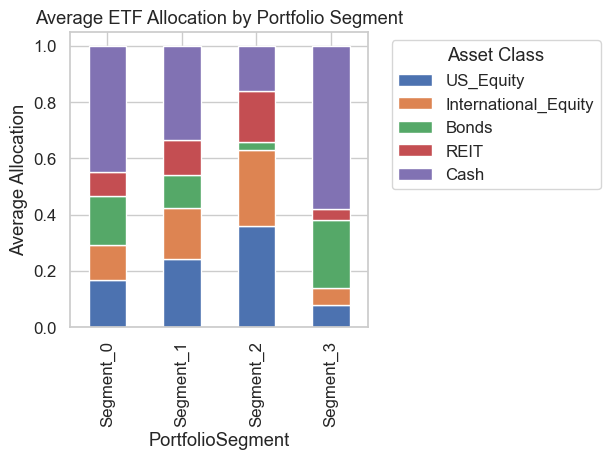

In [84]:
import matplotlib.pyplot as plt

segment_means = df.groupby("PortfolioSegment")[target_cols].mean()

plt.figure(figsize=(8, 6))
segment_means.plot(kind="bar", stacked=True)
plt.ylabel("Average Allocation")
plt.title("Average ETF Allocation by Portfolio Segment")
plt.legend(title="Asset Class", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

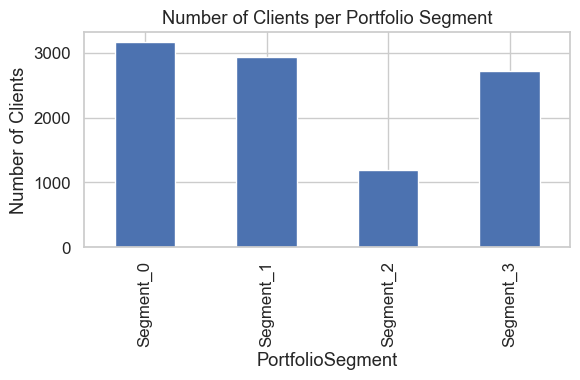

In [85]:
plt.figure(figsize=(6, 4))
df["PortfolioSegment"].value_counts().sort_index().plot(kind="bar")
plt.ylabel("Number of Clients")
plt.title("Number of Clients per Portfolio Segment")
plt.tight_layout()
plt.show()

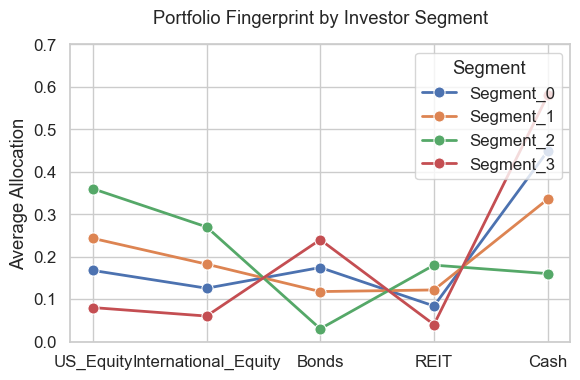

In [86]:
import seaborn as sns
fingerprint_df = (
    segment_means
    .reset_index()                            # PortfolioSegment 變成欄位
    .melt(id_vars="PortfolioSegment",         # 保留 segment
          value_vars=target_cols,             # 展開 5 種資產
          var_name="AssetClass",
          value_name="Allocation")
)

# 排一下 x 軸順序（選擇性，看你想怎麼排）
fingerprint_df["AssetClass"] = pd.Categorical(
    fingerprint_df["AssetClass"],
    categories=target_cols,
    ordered=True
)

# 設定 seaborn style
sns.set_theme(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(6, 4))
sns.lineplot(
    data=fingerprint_df,
    x="AssetClass",
    y="Allocation",
    hue="PortfolioSegment",
    marker="o",
    linewidth=2,
    markersize=8
)

plt.title("Portfolio Fingerprint by Investor Segment", pad=15)
plt.ylabel("Average Allocation")
plt.xlabel("")
plt.ylim(0, 0.7)  # 可依你的數值範圍微調
plt.legend(title="Segment", loc="upper right", frameon=True)
plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_25724\2656489314.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


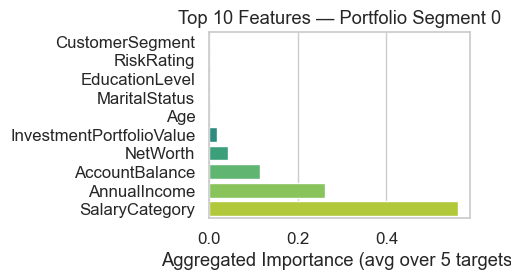

C:\Users\user\AppData\Local\Temp\ipykernel_25724\2656489314.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


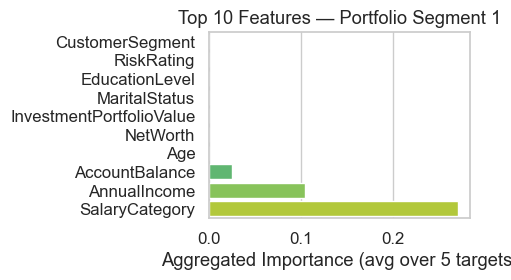

C:\Users\user\AppData\Local\Temp\ipykernel_25724\2656489314.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


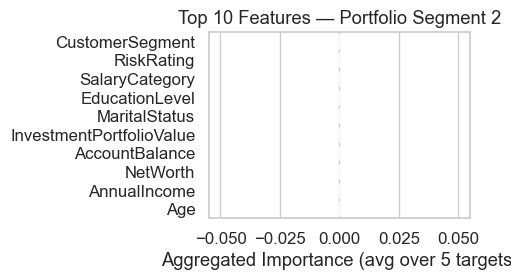

C:\Users\user\AppData\Local\Temp\ipykernel_25724\2656489314.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


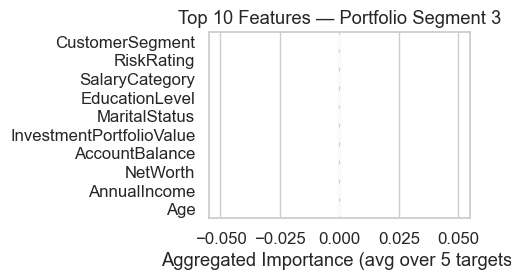

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.1)

# 1. 拿出 one-hot 後的 feature 名稱
feature_names = column_transformer.get_feature_names_out()

# 2. 工具函式：把 one-hot feature 聚合回原始欄位層級（MaritalStatus, SalaryCategory...）
def aggregate_importance(importances, feature_names):
    agg = {}
    for imp, name in zip(importances, feature_names):
        # name 例: "num__Age" 或 "cat__MaritalStatus_Single"
        parts = name.split("__")
        if len(parts) == 2:
            _, rest = parts
        else:
            rest = name
        base = rest.split("_")[0]   # "MaritalStatus_Single" -> "MaritalStatus"
        agg[base] = agg.get(base, 0.0) + float(imp)

    agg_df = pd.DataFrame({
        "Feature": list(agg.keys()),
        "Importance": list(agg.values())
    })
    return agg_df.sort_values("Importance", ascending=False)


# 3. 針對每一個 Segment 畫 feature importance
for s in range(k):
    # 3-1. 先把這個 segment 裡五個 target 的 feature importance 做平均
    avg_importance = np.zeros(len(feature_names))
    for t in target_cols:
        avg_importance += models[s][t].feature_importances_
    avg_importance /= len(target_cols)

    # 3-2. 聚合回原始欄位層級（比較好解釋）
    agg_df = aggregate_importance(avg_importance, feature_names)

    # 取前 top_k 個最重要欄位
    top_k = 10
    top_df = agg_df.head(top_k).iloc[::-1]   # 反轉讓最重要的在最上面

    # 3-3. 畫圖
    plt.figure(figsize=(5, 3))
    sns.barplot(
        data=top_df,
        x="Importance",
        y="Feature",
        palette="viridis"
    )
    plt.title(f"Top {top_k} Features — Portfolio Segment {s}")
    plt.xlabel("Aggregated Importance (avg over 5 targets)")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()
